In [1]:
##
## UNet 
##
## Взята идея по описанию из https://github.com/pietz/unet-keras
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.13.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model, load_model, Input, Model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, UpSampling2D, ZeroPadding2D
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense, Permute
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.6'

In [7]:
#---------------------------------------------------------------------

In [8]:
!ls -la ..
!ls -la ../Data
!ls -la ../Data/training

total 9
drwxrwxrwx 1 boba boba 4096 июл 25 15:24 .
drwxrwxrwx 1 boba boba    0 июл 25 09:21 ..
drwxrwxrwx 1 boba boba 4096 июл 25 09:23 Data
drwxrwxrwx 1 boba boba    0 июл 25 09:22 Data-Arch
drwxrwxrwx 1 boba boba    0 июл 25 09:26 Data-Keras
drwxrwxrwx 1 boba boba  448 июл 25 15:26 .git
-rwxrwxrwx 2 boba boba  130 июл  9 12:02 .gitignore
drwxrwxrwx 1 boba boba    0 июл 25 12:51 Jupyter
drwxrwxrwx 1 boba boba  296 июл 25 15:22 Jupyter-Net
drwxrwxrwx 1 boba boba    0 июл 25 12:32 Temp
drwxrwxrwx 1 boba boba    0 июл 25 09:25 Work
total 16
drwxrwxrwx 1 boba boba 4096 июл 25 09:23 .
drwxrwxrwx 1 boba boba 4096 июл 25 15:24 ..
-rwxrwxrwx 2 boba boba 1060 июн 13 15:55 null_submission_generator.py
-rwxrwxrwx 2 boba boba 1197 июн 13 16:03 random_submission_generator.py
drwxrwxrwx 1 boba boba    0 июл 24 23:10 testing
drwxrwxrwx 1 boba boba    0 июл 25 08:14 training
total 220
drwxrwxrwx 1 boba boba      0 июл 25 08:14 .
drwxrwxrwx 1 boba boba   4096 июл 25 09:23 ..
-rwxrwxrwx 2 boba boba  14

In [9]:
dirData = '../Data'
dirTemp = '../Temp'
dirWork = '../Work'

dirTest  = os.path.join(dirData,'testing','images')
dirTrain = os.path.join(dirData,'training','images')
dirMask  = os.path.join(dirData,'training','truth')

In [10]:
listTrain = os.listdir(dirTrain)
listMask  = os.listdir(dirMask)
listTest  = os.listdir(dirTest)
listTrain = [xx for xx in listTrain if os.path.splitext(xx)[1]=='.tif']
listMask  = [xx for xx in listMask  if os.path.splitext(xx)[1]=='.png']
listTest  = [xx for xx in listTest  if os.path.splitext(xx)[1]=='.tif']
print(len(listTrain),len(listMask),len(listTest))
print(listTrain[:5],'\n',listMask[:5],'\n',listTest[:5])

168 168 162
['i105404.tif', 'i117557.tif', 'i124017.tif', 'i130790.tif', 'i137857.tif'] 
 ['i105404_mask.png', 'i117557_mask.png', 'i124017_mask.png', 'i130790_mask.png', 'i137857_mask.png'] 
 ['i105047.tif', 'i116596.tif', 'i137649.tif', 'i140176.tif', 'i142099.tif']


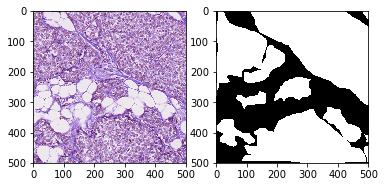

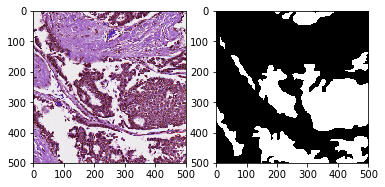

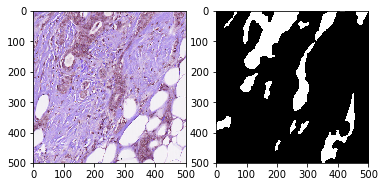

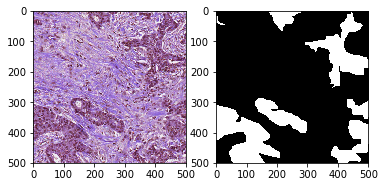

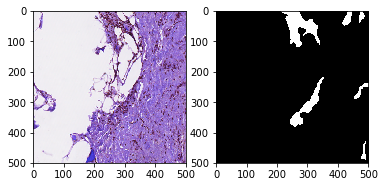

In [97]:
for xx in listTrain[:5] :
    img = cv.imread(os.path.join(dirTrain,xx),-1)
    xxm = os.path.splitext(xx)[0]+"_mask.png"
    msk = cv.imread(os.path.join(dirMask,xxm),-1)
    plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(msk,'gray'); plt.show()
plt.close()

In [256]:
msk.shape, img.shape, img.min(), img.max(), msk.max(), #img[6:10,6:10], msk[6:10,6:10]

((500, 500), (512, 512, 3), 0.0, 0.96862745098039216, 255)

In [257]:
flagGray = False
Gauss    = True
Median   = True
if flagGray :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,1)), np.zeros((512,512,1))
else :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,3)), np.zeros((512,512,1))

for xx in listTrain :
    img = cv.imread(os.path.join(dirTrain,xx),-1)
    if 1 : 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(3,3),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],5);
    xxm = os.path.splitext(xx)[0]+"_mask.png"
    msk = cv.imread(os.path.join(dirMask,xxm),-1)
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trX0[6:506,6:506,0] = img[:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
    else :
        trX0[6:506,6:506,:] = img[:,:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
        trY0[trY0>=0.5] = 1.0
    trX.append(trX0.copy())
    trY.append(trY0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trX = np.array(trX)
trY = np.array(trY)
    
trX.shape, trX.min(), trX.max(), trY.shape, trY.min(), trY.max()
#[trY[xx].mean() for xx in range(10)]

((168, 512, 512, 3), 0.0, 0.9882352941176471, (168, 512, 512, 1), 0.0, 1.0)

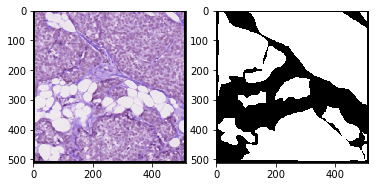

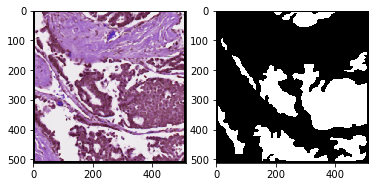

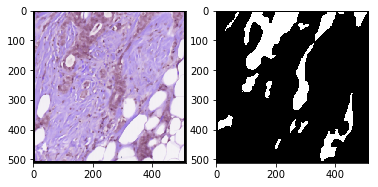

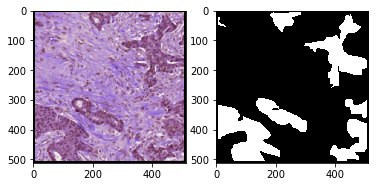

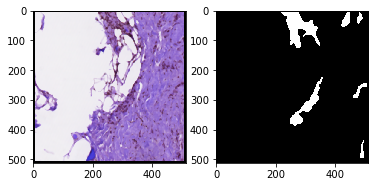

In [258]:
for xx in range(5) :
    img = trX[xx]
    xxm = trY[xx]
    plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(xxm[:,:,0],'gray'); plt.show()
plt.close()

In [259]:
#
# model UNET
#
#    https://github.com/pietz/unet-keras
#
#

def level_block(m, dim, depth, acti):
    if depth > 0:
        
        x = BatchNormalization(axis=3)(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(x) #(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(n)
        n = Dropout(0.25)(n) ## add
        m = MaxPooling2D((2, 2))(n)
        m = level_block(m, 2*dim, depth-1, acti)
        m = UpSampling2D((2, 2))(m)
        m = Conv2D(dim, (2, 2), activation=acti, padding='same')(m)
        m = Dropout(0.25)(m) ## add
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
    return Conv2D(dim, (3, 3), activation=acti, padding='same')(m)

def UNet(img_shape, n_out=2, dim=64, depth=4, acti='relu', flatten=False):
    i = Input(shape=img_shape)
    ## ???? i = ZeroPadding2D((6,6),data_format="channels_last")
    o = level_block(i, dim, depth, acti)
    o = Conv2D(n_out, (1, 1), name='prediction')(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    #o = Activation('relu')(o)
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)


In [260]:
model10 = UNet((512,512,3),depth=4,n_out=1)
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_5 (BatchNorm (None, 512, 512, 3)   12          input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_23 (Conv2D)               (None, 512, 512, 64)  1792        batch_normalization_5[0][0]      
____________________________________________________________________________________________________
conv2d_24 (Conv2D)               (None, 512, 512, 64)  36928       conv2d_23[0][0]                  
___________________________________________________________________________________________

In [261]:
def buildModel (input_shape) :
    model = UNet(input_shape,depth=4,n_out=1)
    
    sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer=sgd, #sgd, #"adam", #'rmsprop',
                  metrics=['binary_accuracy']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [262]:
K.clear_session()
model10 = buildModel((trX.shape[1],trX.shape[2],trX.shape[3]))
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 512, 512, 3)   12          input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 64)  1792        batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 64)  36928       conv2d_1[0][0]                   
___________________________________________________________________________________________

In [263]:
#K.clear_session()
#metric = 'acc'
#model10.compile(loss= 'binary_crossentropy', 
                #'mean_squared_error', #'mean_absolute_error',  #'binary_crossentropy','categorical_crossentropy',
#                  optimizer="rmsprop", #sgd, #"adam", #'rmsprop',
#                  metrics=[metrics]) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])


In [264]:
#model10.load_weights('../Data-Keras/Models/model-UNet-weights.h5', by_name=False)

In [265]:
epochs     = 100
verbose    = 2
batch_size = 2
metric     = 'binary_accuracy'

early_stopping = EarlyStopping(monitor='val_loss', patience=7,min_delta=0.0001,verbose=1)
reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001,verbose=1)
reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.5,patience=3, min_lr=0.000001,verbose=1)

filepath="../Temp/TrainModel001/V1-UNET-{val_"+metric+":.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')


step = 40
low  = 0
high = low+step

print(datetime.datetime.now(),'Training')
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit(trX,trY,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.20, 
                    initial_epoch = 0,
                    callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                    verbose=verbose)

print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)

2017-07-25 20:38:15.461284 Training
Train on 134 samples, validate on 34 samples
Epoch 1/100
Epoch 00000: val_binary_accuracy improved from -inf to 0.66058, saving model to ../Temp/TrainModel001/V1-UNET-0.6606.hdf5
138s - loss: 0.3270 - binary_accuracy: 0.6931 - val_loss: 0.3299 - val_binary_accuracy: 0.6606
Epoch 2/100
Epoch 00001: val_binary_accuracy improved from 0.66058 to 0.67273, saving model to ../Temp/TrainModel001/V1-UNET-0.6727.hdf5
136s - loss: 0.2131 - binary_accuracy: 0.7904 - val_loss: 0.3229 - val_binary_accuracy: 0.6727
Epoch 3/100
Epoch 00002: val_binary_accuracy improved from 0.67273 to 0.72787, saving model to ../Temp/TrainModel001/V1-UNET-0.7279.hdf5
136s - loss: 0.1952 - binary_accuracy: 0.8052 - val_loss: 0.2701 - val_binary_accuracy: 0.7279
Epoch 4/100
Epoch 00003: val_binary_accuracy improved from 0.72787 to 0.81165, saving model to ../Temp/TrainModel001/V1-UNET-0.8116.hdf5
136s - loss: 0.1821 - binary_accuracy: 0.8182 - val_loss: 0.1881 - val_binary_accuracy: 0

In [266]:
%time trP = model10.predict(trX,batch_size=batch_size)

CPU times: user 35.7 s, sys: 6.62 s, total: 42.4 s
Wall time: 40.8 s


(512, 512, 3) (512, 512, 1) (168, 512, 512, 1) 0.0 1.0


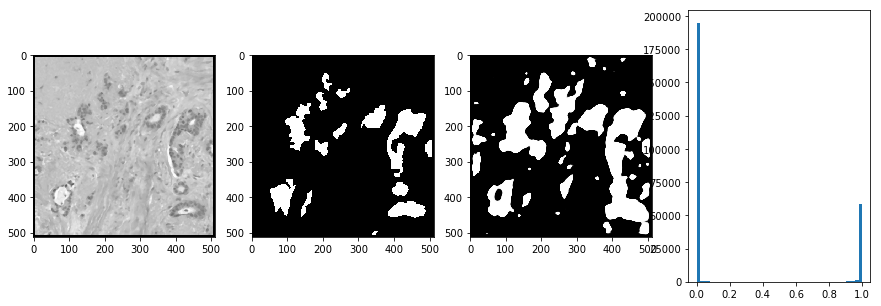

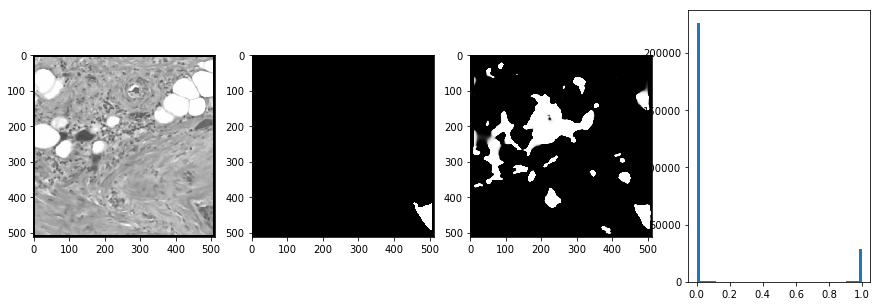

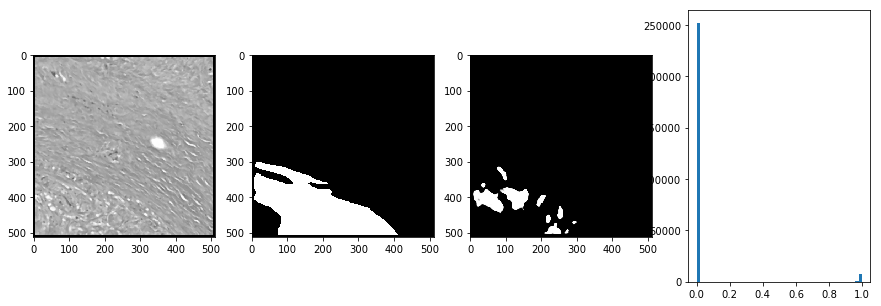

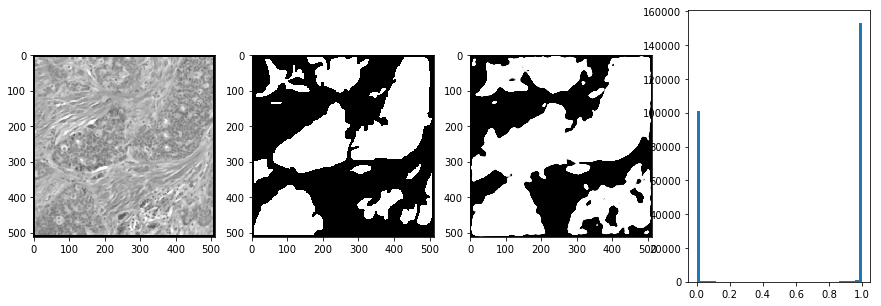

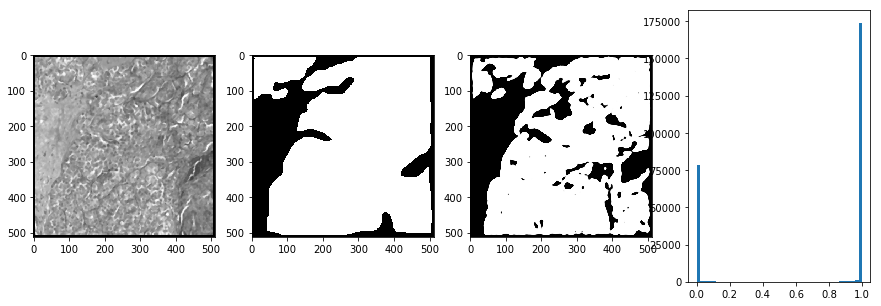

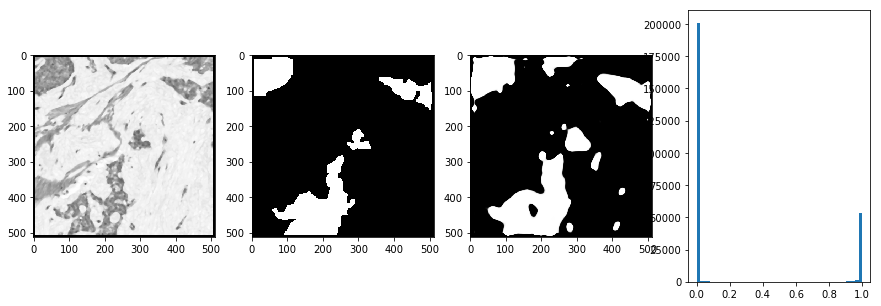

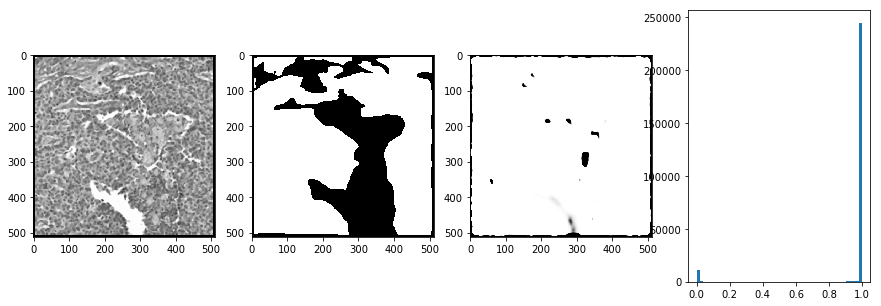

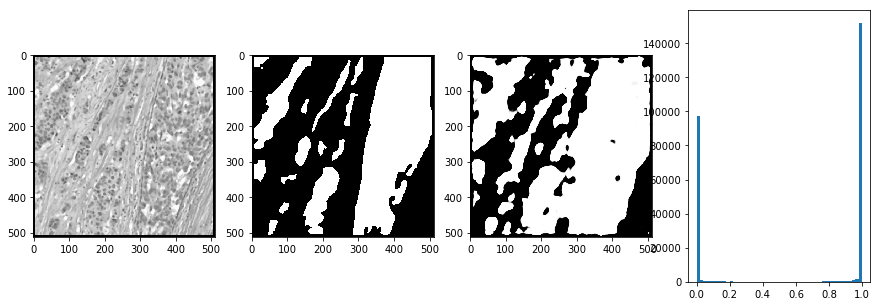

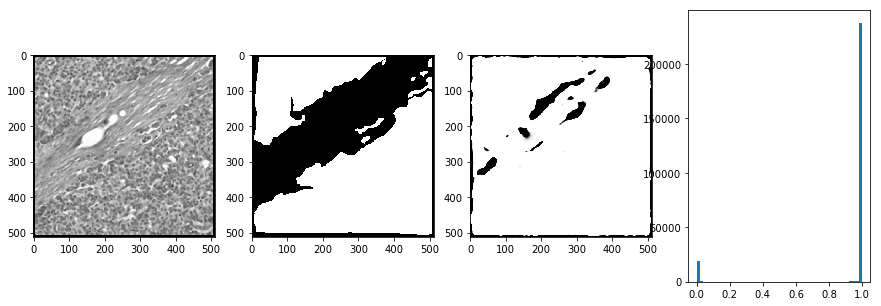

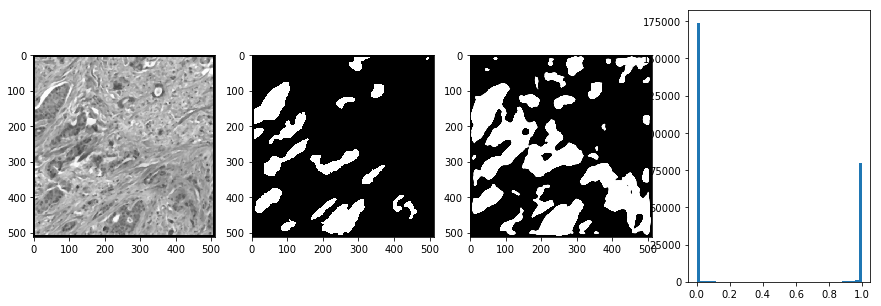

In [274]:
iii = 91
print(trX[0].shape,trY[0].shape,trP.shape,trP.min(),trP.max())
for ii in range(iii,iii+10) :
    plt.figure(figsize=(15,5))
    plt.subplot(141); plt.imshow(trX[ii,:,:,0],'gray'); 
    plt.subplot(142); plt.imshow(trY[ii,:,:,0],'gray'); 
    plt.subplot(143); plt.imshow(trP[ii,:,:,0],'gray'); 
    plt.subplot(144); plt.hist(trP[ii,:,:,0].ravel(),bins=50); 
    plt.show()
plt.close()

In [34]:
#print(model10.evaluate(trX,trY,verbose=2))
print(trY.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64))))

(12048, 17)
(12048, 17)
fbeta_score= 0.173389774236
fbeta_pred = 0.132663262316


In [35]:
fresList=[]

In [36]:
if False :
    save_model(model10,'../Data-Keras/Models/model-UNet.h5')
    model10.save_weights('../Data-Keras/Models/model-UNet-weights.h5')

In [37]:
print(trY.shape)
fres = []
for i in range(trY.shape[1]) :
    if i<>3 :
        cm = skm.confusion_matrix(trY[:,i],trP[:,i])
        tp = len(trP[trP[trY[:,i]==1,i]==1,i])
        tn = len(trP[trP[trY[:,i]==0,i]==0,i])
        fx = len(trP[trP[:,i]<>trY[:,i],i])
        print('{} acc={} roc={} not={} yes={} no={} true={}'.format(i,
              skm.accuracy_score(trY[:,i],trP[:,i]),
              #skm.accuracy_score(trY[:,i],trP[:,i]),
              skm.roc_auc_score(trY[:,i],trP[:,i]),
              cm[0,1]+cm[1,0],
              tp,tn,
              len(trY[trY[:,i]==1,i])
             ))
        fres.append ((i,trY.shape[0],
                skm.accuracy_score(trY[:,i],trP[:,i]),
                #skm.accuracy_score(trY[:,i],trP[:,i]),
                skm.roc_auc_score(trY[:,i],trP[:,i]),
                  cm[0,1]+cm[1,0]))
fresList.append(fres)

(12048, 17)
0 acc=0.776145418327 roc=0.5 not=2697 yes=0 no=9351 true=2697
1 acc=0.182851925631 roc=0.5 not=9845 yes=0 no=2203 true=9845
2 acc=0.737300796813 roc=0.5 not=3165 yes=0 no=8883 true=3165
4 acc=0.841550464807 roc=0.5 not=1909 yes=0 no=10139 true=1909
5 acc=0.952689243028 roc=0.5 not=570 yes=0 no=11478 true=570
6 acc=0.852589641434 roc=0.5 not=1776 yes=0 no=10272 true=1776
7 acc=0.92114873838 roc=0.5 not=950 yes=0 no=11098 true=950


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 2697
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 9351
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 9845
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 2203
/home/boba/anaconda2

8 acc=0.997011952191 roc=0.5 not=36 yes=0 no=12012 true=36
9 acc=0.173389774236 roc=0.5 not=9959 yes=2089 no=0 true=2089
10 acc=0.397327357238 roc=0.5 not=7261 yes=0 no=4787 true=7261
11 acc=0.997509960159 roc=0.5 not=30 yes=0 no=12018 true=30
12 acc=0.990454847278 roc=0.5 not=115 yes=0 no=11933 true=115
13 acc=0.997343957503 roc=0.5 not=32 yes=0 no=12016 true=32
14 acc=0.998256972112 roc=0.5 not=21 yes=0 no=12027 true=21
15 acc=0.997343957503 roc=0.5 not=32 yes=0 no=12016 true=32
16 acc=0.998920982736 roc=0.5 not=13 yes=0 no=12035 true=13


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 2089
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 9959
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 7261
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 4787
/home/boba/anaconda2

In [38]:
cm, trY[trY[:,16]==1],trY[0:16,16],trP[0:16,16]

(array([[12035,     0],
        [   13,     0]]),
 array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.], 

In [39]:
fresList[-1],np.array(fresList)[-1][:,4].sum()

([(0, 12048, 0.77614541832669326, 0.5, 2697),
  (1, 12048, 0.1828519256308101, 0.5, 9845),
  (2, 12048, 0.73730079681274896, 0.5, 3165),
  (4, 12048, 0.84155046480743689, 0.5, 1909),
  (5, 12048, 0.95268924302788849, 0.5, 570),
  (6, 12048, 0.85258964143426297, 0.5, 1776),
  (7, 12048, 0.92114873837981404, 0.5, 950),
  (8, 12048, 0.99701195219123506, 0.5, 36),
  (9, 12048, 0.17338977423638779, 0.5, 9959),
  (10, 12048, 0.39732735723771578, 0.5, 7261),
  (11, 12048, 0.99750996015936255, 0.5, 30),
  (12, 12048, 0.99045484727755639, 0.5, 115),
  (13, 12048, 0.99734395750332006, 0.5, 32),
  (14, 12048, 0.99825697211155373, 0.5, 21),
  (15, 12048, 0.99734395750332006, 0.5, 32),
  (16, 12048, 0.99892098273572372, 0.5, 13)],
 38411.0)

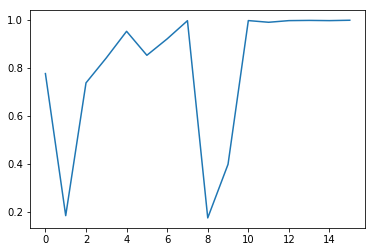

In [40]:
fresList
plt.plot([acc for i,all,acc,roc,nt in fresList[-1]]); 
#plt.plot([acc for i,all,acc,roc,nt in fresList[-2]]); 
plt.show()
#plt.plot([nt for i,all,acc,roc,nt in fresList[-1]]); 
#plt.plot([nt for i,all,acc,roc,nt in fresList[-3]]); 
#plt.show()

In [91]:
trY[0],trP[0]
for i in range(trY.shape[1]) :
    print(i,trY[trY[:,i]==1,:].shape[0])

0 670
1 9272
2 3035
3 6979
4 1824
5 930
6 2005
7 1088
8 51
9 531
10 1820
11 15
12 200
13 88
14 82
15 82
16 33


In [75]:
resAll = resAll+result

In [30]:
model = model1

In [79]:
save_model(model,'../Data-Keras/train-model-2D-2-v2-all.h5')
model.save_weights('../Data-Keras/train-model-2D-2-v2-weights.h5')  # save weights after training

In [31]:
rr, rrx = [], []; trP = model.predict(trX, batch_size=128)
for i in range(trP.shape[1]) :
    xx = [];
    trYY = trY[:,i].astype(np.float64)
    trPY = trP[:,i]
    for ii in range(100) :
        trPP = (trPY>0.01*ii).astype(np.float64)
        #x = fbeta_score(trY[:,0], np.array(trP[:,0] > 0.1*ii), beta=2, average='samples')
        x = K.get_value(fbeta_pred(trYY,trPP))
        xx.append(x)
    rrr = np.array(xx).argmax();
    rr.append(rrr)
    rrx.append(xx[rrr])
    print(datetime.datetime.now(),i,'-->',rrr,xx[rrr],xx[(rrr-1):(rrr+2)])
    #print(xx);
    #plt.plot(np.array(xx)); plt.show()
trM = np.array(rr)/100.0;

2017-05-20 05:22:01.009723 0 --> 70 0.758419290079 [0.75741733368803943, 0.75841929007857778, 0.75785138394714635]
2017-05-20 05:22:23.972821 1 --> 78 0.982638483662 [0.98262473453994426, 0.98263848366246676, 0.98259679666709321]
2017-05-20 05:22:52.632376 2 --> 58 0.847226297632 [0.8469111862002846, 0.84722629763157453, 0.84682213028656683]
2017-05-20 05:23:27.033547 3 --> 78 0.97604678248 [0.97585536488705449, 0.97604678247993626, 0.97586138532621902]
2017-05-20 05:24:07.288213 4 --> 39 0.78729476795 [0.78664609854346335, 0.78729476795032916, 0.78707371492899492]
2017-05-20 05:24:52.980975 5 --> 42 0.789568102568 [0.78871126051941221, 0.78956810256787635, 0.78669767415698355]
2017-05-20 05:25:44.022237 6 --> 47 0.830831644043 [0.8305167161398419, 0.83083164404299403, 0.83015444819651052]
2017-05-20 05:26:40.712293 7 --> 45 0.738016164169 [0.73686966073098015, 0.73801616416924898, 0.73773213859960107]
2017-05-20 05:27:43.679293 8 --> 26 0.676190170231 [0.6690774577597115, 0.6761901702

In [26]:
model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [27]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [34]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-20 05:46:19.287685 61191 61191
2017-05-20 05:46:38.218814 	 0 	 5000 	 test_14523.jpg 	 
2017-05-20 05:46:51.023731 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-20 05:46:58.884016 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-20 05:47:09.507695 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-20 05:47:16.475888 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-20 05:47:26.837760 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-20 05:47:33.858034 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-20 05:47:44.019579 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-20 05:47:51.298769 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-20 05:48:01.555641 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-20 05:48:24.538867 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-20 05:48:40.785101 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-20 05:48:43.863555


In [36]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [30]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  6.56801313e-02,   7.46541142e-01,   2.32726157e-01,
          9.55386758e-01,   1.95543230e-01,   9.11955476e-01,
          8.89197826e-01,   2.53069662e-02,   1.54045611e-05,
          7.43342913e-04,   6.54759035e-02,   6.17289741e-04,
          8.51887614e-02,   2.95602629e-04,   2.64362683e-07,
          1.03749386e-04,   2.92145728e-07], dtype=float32))

In [38]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
tt=trM; trM[:]=0.5
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [39]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.63650557e-01   3.91220033e-01   1.36160061e-01   9.47374701e-01
   9.09343541e-01   1.55211976e-02   3.13203782e-02   1.42206885e-02
   8.06170846e-08   9.10553038e-01   7.85041321e-03   4.12757437e-08
   6.71853591e-03   1.33155788e-06   7.46736941e-06   9.65268737e-06
   7.95199711e-08]


In [40]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
